In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [4]:
#reading dataset
exchange_data = pd.read_csv('forex_data_10y.csv')
exchange_data.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,25-Aug-20,74.327,74.100,74.335,74.075,0.92K,0.22%
1,24-Aug-20,74.168,74.922,74.922,73.962,4.90K,-1.01%
2,23-Aug-20,74.922,74.922,74.922,74.922,0,0.00%
3,21-Aug-20,74.920,74.980,75.005,74.820,3.16K,-0.12%
4,20-Aug-20,75.012,74.973,75.132,74.935,3.70K,0.22%


In [5]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [6]:
#checking first few records of the dataset
ind_exchange_data.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2020-08-25,74.327,74.100,74.335,74.075,0.92K,0.22%
2020-08-24,74.168,74.922,74.922,73.962,4.90K,-1.01%
2020-08-23,74.922,74.922,74.922,74.922,0,0.00%
2020-08-21,74.920,74.980,75.005,74.820,3.16K,-0.12%
2020-08-20,75.012,74.973,75.132,74.935,3.70K,0.22%


In [7]:
# sorting the dataset in ascending order of date
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Chg%,High,Low,Open,Price,Volume
Date,,,,,,
2010-09-13,0.05%,46.415,46.100,46.220,46.310,0
2010-09-14,-0.09%,46.465,46.070,46.270,46.270,0
2010-09-15,-0.15%,46.460,46.080,46.160,46.200,0
2010-09-16,-0.12%,46.415,46.075,46.145,46.145,0
2010-09-17,-0.63%,46.128,45.785,46.085,45.855,0


<AxesSubplot:xlabel='Date'>

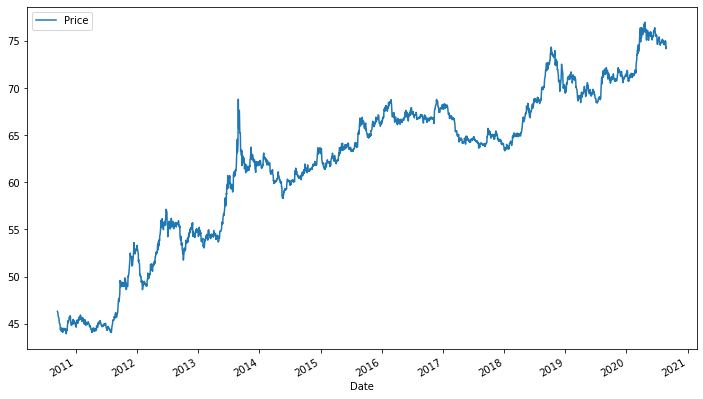

In [8]:
df = data_frame[["Price"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

In [9]:
diff = df.index.values[-1] - df.index.values[0]

days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2010 to %d"%(2010 + int(0.8*years)))

Total data: 9 years
80 percent data = 2010 to 2017


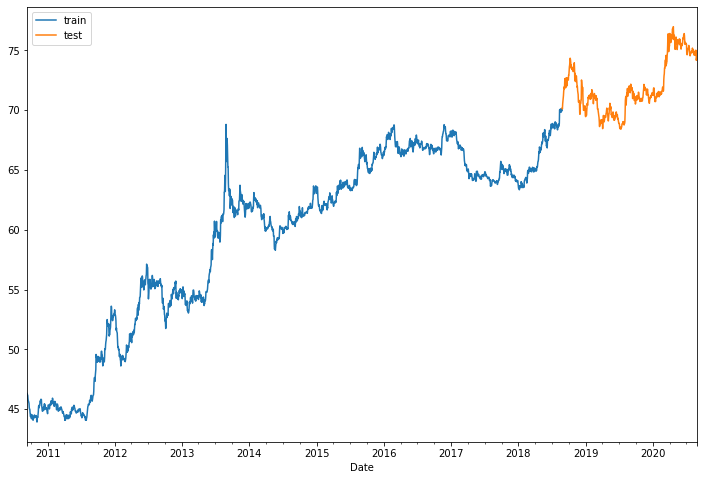

In [10]:
split_date = pd.Timestamp('26-08-2018')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

In [9]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)


In [10]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [42]:
#Data pre processing required to turn it into a 3D array
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

X_tst_t.shape

(522, 1, 1)

In [12]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
2086/2086 [==============================] - 2s 740us/step - loss: 0.0857 - rmse: 0.2928
Epoch 2/100
2086/2086 [==============================] - 2s 738us/step - loss: 0.0021 - rmse: 0.0462
Epoch 3/100
2086/2086 [==============================] - 2s 756us/step - loss: 0.0017 - rmse: 0.0415
Epoch 4/100
2086/2086 [==============================] - 2s 734us/step - loss: 0.0018 - rmse: 0.0425
Epoch 5/100
2086/2086 [==============================] - 2s 739us/step - loss: 0.0018 - rmse: 0.0424
Epoch 6/100
2086/2086 [==============================] - 1s 715us/step - loss: 0.0018 - rmse: 0.0421
Epoch 7/100
2086/2086 [==============================] - 1s 716us/step - loss: 0.0018 - rmse: 0.0419
Epoch 8/100
2086/2086 [==============================] - 1s 717us/step - loss: 0.0017 - rmse: 0.0418
Epoch 00008: early stopping


In [14]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_lstm)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_lstm)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_lstm)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Train set is:	0.959
The  MAE on the Train set is:	0.185
The  RMSE on the Train set is:	0.203
The Adjusted R2 score on the Train set is:	0.959

The R2 score on the Test set is:	0.701
The Adjusted R2 score on the Test set is:	0.701
The  MAE on the Test set is:	0.118
The  RMSE on the Test set is:	0.161


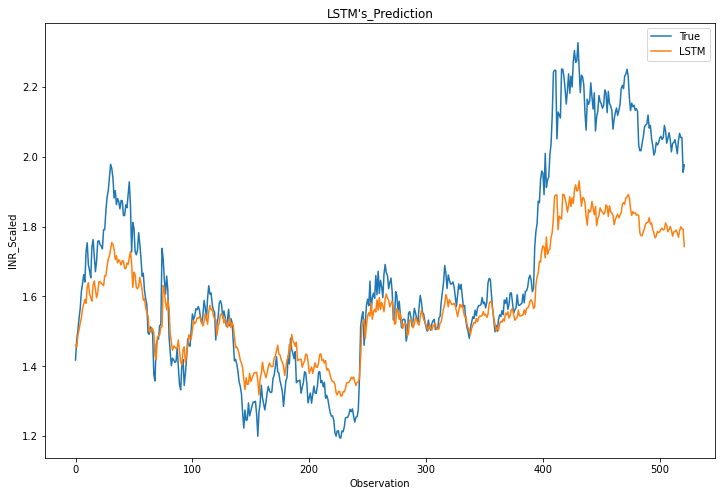

In [15]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [34]:
lstm_results = sc.inverse_transform(y_pred_test_lstm)
print(lstm_results[-50:])
X_tst_t.shape

[[73.631744]
 [73.687706]
 [73.616486]
 [73.3782  ]
 [73.23314 ]
 [73.31498 ]
 [73.275566]
 [73.292244]
 [73.23668 ]
 [73.25436 ]
 [73.22658 ]
 [72.85336 ]
 [72.79587 ]
 [72.795364]
 [72.88361 ]
 [72.951675]
 [73.057556]
 [73.07773 ]
 [73.0863  ]
 [73.184685]
 [73.04243 ]
 [73.07016 ]
 [72.927475]
 [72.85336 ]
 [72.74744 ]
 [72.78275 ]
 [72.88613 ]
 [72.858406]
 [72.87857 ]
 [72.933525]
 [72.953186]
 [72.9174  ]
 [72.938065]
 [73.072685]
 [73.010666]
 [72.87756 ]
 [72.928986]
 [72.99201 ]
 [72.913864]
 [72.78275 ]
 [72.87353 ]
 [72.88412 ]
 [72.91588 ]
 [72.84983 ]
 [72.76257 ]
 [72.901764]
 [72.98545 ]
 [72.93907 ]
 [72.94008 ]
 [72.559525]]


(522, 1, 1)

In [47]:
#Predict future iterations 

test_predictions= []

current_batch = X_tst_t



for i in range(0, 3):
    
    first_eval_batch = model_lstm.predict(current_batch)[0]
    
    test_predictions.append(first_eval_batch)
    
    
    current_batch= np.delete(current_batch, 0)
    current_batch = np.reshape(current_batch, (1, len(current_batch), 1))
    
    print(test_predictions)




    

[array([1.4599388], dtype=float32)]
[array([1.4599388], dtype=float32), array([125.28924], dtype=float32)]
[array([1.4599388], dtype=float32), array([125.28924], dtype=float32), array([35.33603], dtype=float32)]
